In [ ]:
#Understanding the business problem:

#A company is collecting the emails of visitors to its prelaunch page.
#The plan is to collect as many emails as possible for the website launch.
#My goal is to design,run and analyze an A/B experiment which tests two versions of the prelaunch page.

#The control group will be seeing the blue button which is the current version
#The treatment group will be seeing the green button which is the new recommended feature
#The driver metric being tested is the sign-up rate.

In [129]:
#First import all neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.stats as stats
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.power import tt_ind_solve_power,TTestIndPower
from statsmodels.stats.proportion import proportions_chisquare,confint_proportions_2indep,proportions_ztest

from warnings import filterwarnings
filterwarnings("ignore")

In [10]:
#Firstly to ensure reproducibility of the results in experiment set the seed
np.random.seed(123)

#load pretest and test files
#our pretest is before the A/B test and acts as the baseline, it ensures both control and treatment groups are the same
#our test contains data collected during the A/B test,it measures the effect of the change we are testing
pretest=pd.read_csv("../Data/pretest.csv")
test=pd.read_csv("../Data/test.csv")

#convert date column in both pretest and test to datetime
pretest["date"]=pd.to_datetime(pretest["date"])
test["date"]=pd.to_datetime(test["date"])

In [11]:
pretest.head()

,visitor_id,date,email,experiment,group,submitted
0,1,2021-12-01,NaN,NaN,NaN,0
1,2,2021-12-01,NaN,NaN,NaN,0
2,3,2021-12-01,NaN,NaN,NaN,0
3,4,2021-12-01,NaN,NaN,NaN,0
4,5,2021-12-01,NaN,NaN,NaN,0


In [12]:
pretest.tail()

,visitor_id,date,email,experiment,group,submitted
309898,309899,2021-12-31,scalderon@example.net,NaN,NaN,1
309899,309900,2021-12-31,NaN,AA_test,0.0,0
309900,309901,2021-12-31,NaN,NaN,NaN,0
309901,309902,2021-12-31,NaN,NaN,NaN,0
309902,309903,2021-12-31,NaN,NaN,NaN,0


In [42]:
#some stats about the pretest dataset
print(f"There is {pretest.shape[0]} records and {pretest.shape[1]} columns in the pretest dataset")
print(f"The date ranges from {pretest['date'].min()} to {pretest['date'].max()}")
print(f"There is a total number of {pretest['visitor_id'].nunique()} visitors to the website")
print(f"The total sign ups are {pretest['submitted'].sum()}")
print(f"The baseline sign up rate is {pretest['submitted'].mean().round(2)}")

There is 309903 records and 6 columns in the pretest dataset
The date ranges from 2021-12-01 00:00:00 to 2021-12-31 00:00:00
There is a total number of 309903 visitors to the website
The total sign ups are 31295
The baseline sign up rate is 0.1


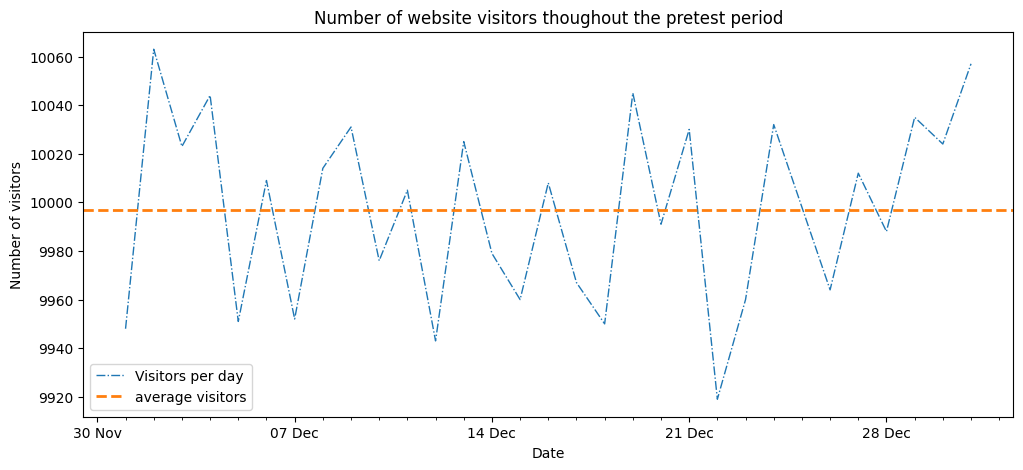

In [ ]:
#visualizing how the number of visitors changes throughout the pretest period

#set colour palette for the plot
colors=sn.color_palette()
c1,c2=colors[0],colors[1]

visitors_per_day=pretest.groupby("date")["submitted"].count()
average_visitors_per_day=visitors_per_day.mean()

figure,axis=plt.subplots(figsize=(12,5))

axis.plot(visitors_per_day.index,visitors_per_day,linewidth=1,label="Visitors per day",color=c1,linestyle="dashdot")
axis.axhline(average_visitors_per_day,color=c2,label="average visitors",linestyle="--",linewidth=2)

#now some formatting
axis.xaxis.set_major_locator(mdates.DayLocator(interval=7))
axis.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
axis.xaxis.set_minor_locator(mdates.DayLocator())

#now some labelling
plt.title("Number of website visitors thoughout the pretest period")
plt.xlabel("Date")
plt.ylabel("Number of visitors")
plt.legend()
plt.show()

#Daily visitors fluctuates as expected but stays near the average
#The traffic appears stable and consistent which supports the validity of the pretest period before launching an actual A/B test

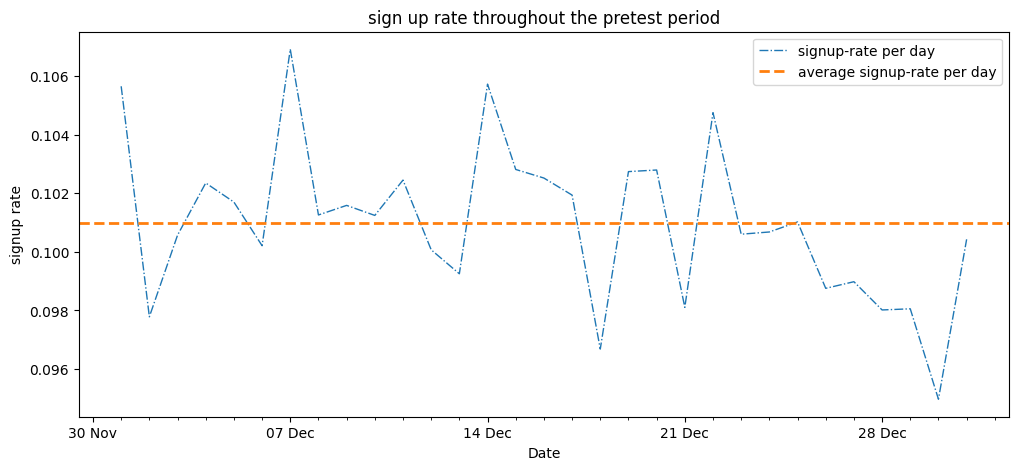

In [39]:
#Visualising how the signup-rate changes throughout the pretest period

signup_rate_perday=pretest.groupby("date")["submitted"].mean()
average_signup_rate_perday=signup_rate_perday.mean()

figure,axis=plt.subplots(figsize=(12,5))

axis.plot(signup_rate_perday.index,signup_rate_perday,color=c1,linestyle="dashdot",linewidth=1,label="signup-rate per day")
axis.axhline(average_signup_rate_perday,color=c2,linestyle="--",linewidth=2,label="average signup-rate per day")

axis.xaxis.set_major_locator(mdates.DayLocator(interval=7))
axis.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
axis.xaxis.set_minor_locator(mdates.DayLocator())

plt.title("sign up rate throughout the pretest period")
plt.xlabel("Date")
plt.ylabel("signup rate")
plt.legend()
plt.show()

In [44]:
#Next we will need to state the experiment hypothesis and set our experiment parameters

#Null hypothesis (Ho): The sign up rates of the blue and green buttons are the same
#Alternative hypothesis (Ha): The sign up rates of the blue and green buttons are different

alpha=0.05 #probability threshold at a 95% confidence interval, if p-value is less than alpha reject Ho
power=0.8 #probability of correctly detecting an effect or difference with statistical significance,is 1-beta (type 2 error)
mde=0.1 #relative lift, detect a 10% improvement in baseline signup-rate (0.1) with statistical significance

#proportions if the effect exists
p1=0.1 #baseline signup rate, control(blue)
p2=p1*(1+mde) #treatment (green)

In [45]:
#Designing the experiment

#Calculating sample size:
#First determine the effect size which is the difference between the control and treatment proportions (p1 and p2):
effect_size=sm.stats.proportion_effectsize(p1,p2)

#Now we can calculate the sample size for each group at our desired level of power and significance level
sample_size=tt_ind_solve_power(effect_size=effect_size,alpha=alpha,power=power)
n=int(round(sample_size,-3)) #round to the nearest thousand
print(f"The total number of samples required for the experiment is {n*2}")


The total number of samples required for the experiment is 30000


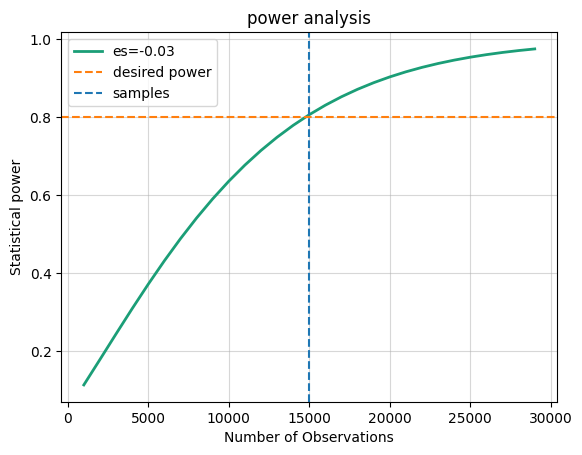

In [ ]:
#Exploring power across different sample sizes

analysis=TTestIndPower()
analysis.plot_power(dep_var="nobs",nobs=np.arange(1000,30000,1000),effect_size=[effect_size],title="power analysis")

plt.axhline(0.8,label="desired power",linestyle="--",color=c2,alpha=1)
plt.axvline(n,label="samples",alpha=1,linestyle="--",color=c1)
plt.ylabel("Statistical power")
plt.grid(alpha=0.5)
plt.legend()
plt.show()

#The visual shows as the sample size increases, the statistical power also increases before almost levelling off
#This suggests that larger sample sizes in an experiment are more likely to correctly reject the null hypothesis
#Given that there is significance in the difference between the control and treatment groups

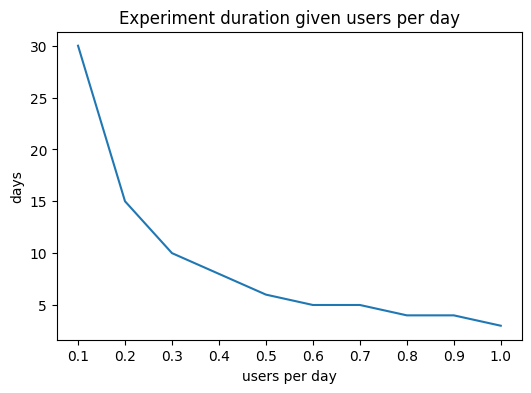

In [68]:
#As part of the experiment design process we also need to calculate the experiment duration
#This is basically how many days it will take us to reach our total sample size given the daily traffic to the website
#we can control how much of this traffic we allocate to our experiment by creating alloc variable

alloc=np.arange(0.1,1.1,0.1)
size=round(average_visitors_per_day,-3)*alloc
days=np.ceil(n*2/size)

#generate plot
figure,axis=plt.subplots(figsize=(6,4))
axis.plot(alloc,days)
axis.xaxis.set_major_locator(MultipleLocator(0.1))
plt.title("Experiment duration given users per day")
plt.xlabel("users per day")
plt.ylabel("days")
plt.show()

#We can visualize that when a lower proportion of traffic is allocated the exerpiment takes longer in days
#Whereas, a higher proportion of traffic being allocated gives a shorter experiment duration

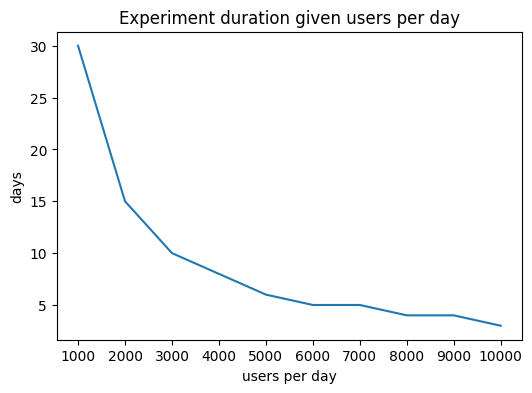

In [67]:
#or we can visualize like this, which will produce the same trend

figure,axis=plt.subplots(figsize=(6,4))
axis.plot(size,days)
axis.xaxis.set_major_locator(MultipleLocator(1000))
plt.title("Experiment duration given users per day")
plt.xlabel("users per day")
plt.ylabel("days")
plt.show()


In [ ]:
#if we have a particular number of days in mind we can calculate how many samples will be required daily to reach 
#the total sample size so we can run the experiment

print(f"for a 7 day experiment we will require {np.ceil(n*2/7)} users per day to run the experiment") #Too risky
print(f"for a 14 day experiment we will require {np.ceil(n*2/14)} users per day to run the experiment") #sweet spot between time and risk
print(f"for a 21 day experiment we will require {np.ceil(n*2/21)} users per day to run the experiment") #Too long to wait

for a 7 day experiment we will require 4286.0 users per day to run the experiment
for a 14 day experiment we will require 2143.0 users per day to run the experiment
for a 21 day experiment we will require 1429.0 users per day to run the experiment


In [77]:
#Before we run our A/B test we should actually run an AA test to assess for validity threats
#In AA test the users are split into control and treatment groups but no feature change is applied to them
#both groups experience the same conditions,thus the AA test acts as our baseline and checks for randomization quality
#so when we do run our A/B test after and we see an effect we can confidently say the effect is statistically significant

#use our pretest dataframe
AA_test=pretest[pretest["experiment"]=="AA_test"]
AA_control=AA_test[AA_test["group"]==0]["submitted"]
AA_treatment=AA_test[AA_test["group"]==1]["submitted"]

#Now we can get some stats for both the control and treatment groups such as number of signups,signuprate,total size of both groups

AA_control_signups=AA_control.sum()
AA_treatment_signups=AA_treatment.sum()
AA_control_signuprate=AA_control.mean()
AA_treatment_signuprate=AA_treatment.mean()
AA_control_count=AA_control.count()
AA_treatment_count=AA_treatment.count()

print(f"In the AA test the signup rate for the control group is {AA_control_signuprate*100:.3}")
print(f"In the AA test the signup rate for the treatment group is {AA_treatment_signuprate*100:.3}")



In the AA test the signup rate for the control group is 10.1
In the AA test the signup rate for the treatment group is 9.88


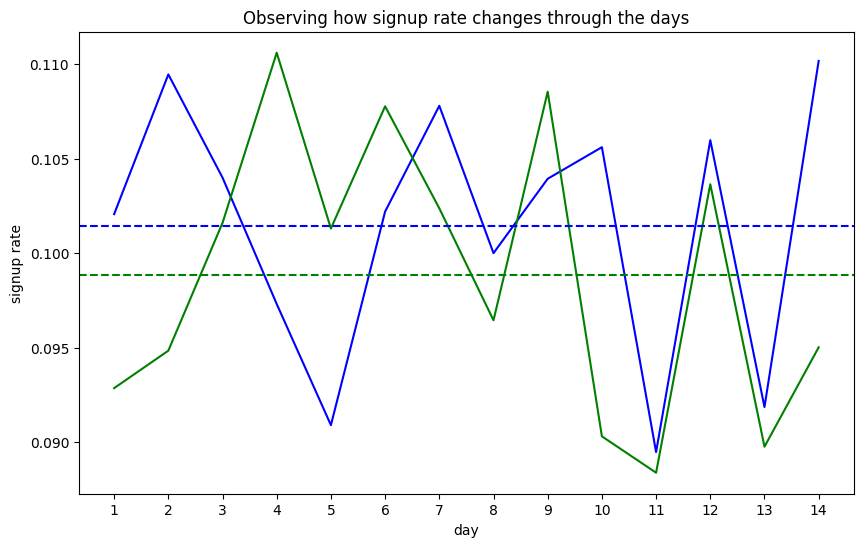

In [ ]:
#Visualizing how the signup rates fluctuate each day for both the control and treatment groups
#In the AA-test using the pretest dataframe

AA_signuprate_perday=AA_test.groupby(["date","group"])["submitted"].mean()
AA_control_proportions=AA_signuprate_perday.xs(0,level="group")
AA_treatment_proportions=AA_signuprate_perday.xs(1,level="group")

#create an array for days so it can be plotted in the visualization
days=range(1,AA_test["date"].nunique()+1)

figure,axis=plt.subplots(figsize=(10,6))
axis.plot(days,AA_control_proportions,color="blue",label="control")
axis.plot(days,AA_treatment_proportions,color="green",label="treatment")
axis.axhline(AA_control_signuprate,label="control signup rate",linestyle="--",color="blue",alpha=1)
axis.axhline(AA_treatment_signuprate,label="treatment signup rate",linestyle="--",color="green",alpha=1)

axis.set_xticks(days)
axis.set_title("Observing how signup rate changes through the days")
axis.set_xlabel("day")
axis.set_ylabel("signup rate")
plt.show()

#from the visual we can see that the signup rates for both control and treatment groups are not far apart
#They also overlap which indicates both groups behave similarily.
#This is what we want in our AA test, we want both groups to be the same.

In [119]:
#In an AA-test we should check for any statistically significant differences between the control and treatment groups
#Even in terms of their proportions such as the number of signups for each group
#Since the outcome is binary (1 or 0 i.e signed-up or not) we can use chi-square test for proportions,
#This will help us assess whether or not the difference in proportions between the control and treatment groups
#is statistically significant
#The chi-square test for proportions compares the actual number of signups (count) for each group to what we would expect given the samples sizes of the groups (nobs)

AA_chi_stat,AA_p,AA_table=proportions_chisquare(count=[AA_control_signups,AA_treatment_signups],nobs=[AA_control_count,AA_treatment_count])

first_date=AA_test["date"].min().date()
last_date=AA_test["date"].max().date()

AA_alpha=0.05 #significance value, will be compared with the p value (AA_p)

print(f"AA-test ran between {first_date}-{last_date}")

#Null and alternative hypothesis
print("The null hypothesis is the signup rates between the control and treatment groups are the same")
print("The alternative hypothesis is the signup rates between the control and treatment groups are different")

if AA_p>AA_alpha:
    print("fail to reject the null hypothesis, the control and treatment groups are the same,proceed to A/B test")
else:
    print("Reject null hypothesis, control and treatment groups are different, results are statistically significant")

#Randomization algorithm worked well, we can move on to A/B test

AA-test ran between 2021-12-18-2021-12-31
The null hypothesis is the signup rates between the control and treatment groups are the same
The alternative hypothesis is the signup rates between the control and treatment groups are different
fail to reject the null hypothesis, the control and treatment groups are the same,proceed to A/B test


In [140]:
#Running A/B test:

AB_test=test[test["experiment"]=="email_test"]
AB_control=AB_test[AB_test["group"]==0]["submitted"]
AB_treatment=AB_test[AB_test["group"]==1]["submitted"]

#collect statistics on both control and treatment groups for A/B test
AB_control_signups=AB_control.sum()
AB_treatment_signups=AB_treatment.sum()
AB_control_signuprate=AB_control.mean() #main kpi of interest
AB_treatment_signuprate=AB_treatment.mean() #main kpi of interest
AB_control_count=AB_control.count()
AB_treatment_count=AB_treatment.count()

print(f"The control signup rate is {AB_control_signuprate*100:.3}")
print(f"The treatment signup rate is {AB_treatment_signuprate*100:.3}")

#There is an improvement or lift in the signup rate for the treatment group in the A/B test
#But is this difference statistically significant ?, this is what will be evaluated later on

The control signup rate is 9.56
The treatment signup rate is 10.8


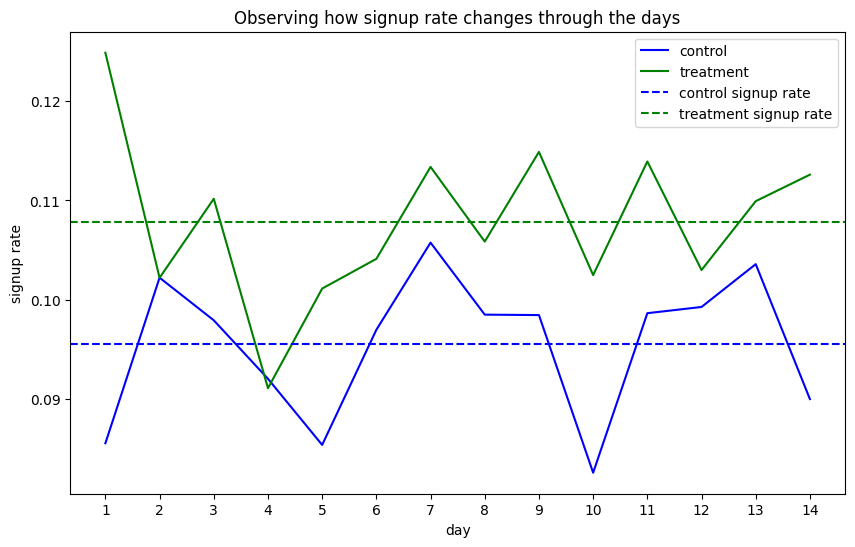

In [141]:
#Visualization of how signup rate for both control and treatment group varies throughout the days in A/B test

AB_test_signuprate_perday=AB_test.groupby(["date","group"])["submitted"].mean()
AB_control_proportions=AB_test_signuprate_perday.xs(0,level="group")
AB_treatment_proportions=AB_test_signuprate_perday.xs(1,level="group")

AB_days=range(1,AB_test["date"].nunique()+1)

figure,axis=plt.subplots(figsize=(10,6))
axis.plot(AB_days,AB_control_proportions,color="blue",label="control")
axis.plot(AB_days,AB_treatment_proportions,color="green",label="treatment")
axis.axhline(AB_control_signuprate,linestyle="--",color="blue",alpha=1,label="control signup rate")
axis.axhline(AB_treatment_signuprate,linestyle="--",color="green",alpha=1,label="treatment signup rate")

#format the plot
axis.set_xticks(days)
axis.set_title("Observing how signup rate changes through the days")
axis.set_xlabel("day")
axis.set_ylabel("signup rate")
plt.legend()
plt.show()

#Compared to the AA test, it can be seen that the difference between the control and treatment signup rate is larger
#In contrast to the AA test plot there is not much overlap between the control and treatment groups


In [142]:
#we need to check for sample-ratio mismatch in the A/B test
#Sample ratio mismatch occurs when the actual split of the traffic in the experiments between the control
#and treatment groups does not match the expected allocation
#A sample ratio mismatch suggests broken randomization logic and could lead to biased results
#To test for sample ratio mismatch,chisqaure goodness of fit test will be used.

AB_test=test[test["experiment"]=="email_test"]
observed=AB_test.groupby("group")["experiment"].count().values
expected=[AB_test.shape[0]*0.5]*2 #we would expect a 50/50 split

AB_chi,AB_p=stats.chisquare(f_obs=observed,f_exp=expected)

SRM_alpha=0.05 #significance value

print("The null hypothesis is the ratio of samples between the control and treatment groups is 1:1")
print("The alternative hypothesis is the ratio of samples between the control and treatment groups is not 1:1")

if AB_p>SRM_alpha:
    print("fail to reject the null hypothesis,there is no sample ratio mismatch, proceed with A/B test")
else:
    print("Reject the null hypothesis, there is sample ratio mismatch")

The null hypothesis is the ratio of samples between the control and treatment groups is 1:1
The alternative hypothesis is the ratio of samples between the control and treatment groups is not 1:1
fail to reject the null hypothesis,there is no sample ratio mismatch, proceed with A/B test


In [143]:
#Conducting statistical inference:

#As the outcome is categorical (binary), the best test for conducting statistical inference and evaluating the results
#of the A/B test is a chisquare test. In particular a proportions chisquare test

successes=[AB_treatment_signups,AB_control_signups] #number of people who signed up in both control and treatment groups
total=[AB_treatment_count,AB_control_count] #total number of users in each group

#two proportions (signup rates) will be generated one for the control and one for the treatment
#These two proportions are then compared and the difference between them is checked for statistical significance

#Run proportions chisquare test
AB_chi,AB_p_value,AB_table=proportions_chisquare(count=successes,nobs=total)

AB_alpha=0.05

#grab the dates
min_date=AB_test["date"].min().date()
max_date=AB_test["date"].max().date()

print(f"A/B test ran between {min_date}-{max_date}")
print("\nNull hypothesis is the signup rates between the blue(control) and green(treatment) buttons is the same")
print("Alternative hypothesis is the signup rates between the blue(control) and green(treatment) buttons are different")
print(f"\nSignificance value is {AB_alpha}")

print(f"\nThe chisquare statistic is {AB_chi:.3f} with a p-value of {AB_p_value:.3f}")

print("\nConclusion:")
if AB_p_value<AB_alpha:
    print("Reject the null hypothesis, the difference in the signup rate between the blue and green buttons is statistically significant")
else:
    print("Fail to reject the null hypothesis, the difference in the signup rates between the blue and green buttons is not statistically significant")

A/B test ran between 2022-02-01-2022-02-14

Null hypothesis is the signup rates between the blue(control) and green(treatment) buttons is the same
Alternative hypothesis is the signup rates between the blue(control) and green(treatment) buttons are different

Significance value is 0.05

The chisquare statistic is 12.312 with a p-value of 0.000

Conclusion:
Reject the null hypothesis, the difference in the signup rate between the blue and green buttons is statistically significant


In [144]:
#we can also use z-test for statistical inference especially for larger sample sizes
#We will specifically use the proportions z-test as our output is categorical
#This again compares two proportions, the proportion of control group (blue) and treatment group (green)

successes=[AB_treatment_signups,AB_control_signups]
total=[AB_treatment_count,AB_control_count]

z_stat,p_value=proportions_ztest(count=successes,nobs=total)

print(f"A/B test ran between {min_date}-{max_date}")
print("\nNull hypothesis is the signup rates between the blue(control) and green(treatment) buttons is the same")
print("Alternative hypothesis is the signup rates between the blue(control) and green(treatment) buttons are different")
print(f"\nSignificance value is {AB_alpha}")

print(f"\nThe z-statistic is {z_stat:.3f} with a p-value of {p_value:.3f}")

print("\nConclusion:")
if p_value<AB_alpha:
    print("Reject the null hypothesis, the difference in signup rates between the control and treatment groups is statistically significant")
else:
    print("Fail to reject the null hypothesis, the difference in signup rates between control and treatment groups is not statistically significant")


A/B test ran between 2022-02-01-2022-02-14

Null hypothesis is the signup rates between the blue(control) and green(treatment) buttons is the same
Alternative hypothesis is the signup rates between the blue(control) and green(treatment) buttons are different

Significance value is 0.05

The z-statistic is 3.509 with a p-value of 0.000

Conclusion:
Reject the null hypothesis, the difference in signup rates between the control and treatment groups is statistically significant


In [145]:
#Confidence interval:

#We need to identify a range of values which contains the actual value of the parameter we are after
#In this case we want the difference in proportions between the control and treatment groups
#This gives us like an effect size with a confidence level of 95%

confidence=confint_proportions_2indep(AB_treatment_signups,AB_treatment_count,AB_control_signups,AB_control_count)
absolute_lower=confidence[0] #absolute lower bound
absolute_upper=confidence[1] #absolute upper bound

relative_lower=absolute_lower/AB_control_signuprate #to see the effect of the treatment we divide by the control signuprate which acts as the baseline
relative_upper=absolute_upper/AB_control_signuprate #likewise here

In [155]:
#Some statistics

print("Samples sizes:")
print(f"The sample size of the control group is {AB_control_count}")
print(f"The sample size of the treatment group is {AB_treatment_count}")

print("\nRelative difference in proportions:")
print(f"The control signup rate is {AB_control_signuprate*100:.1f}%")
print(f"The treatment signup rate is {AB_treatment_signuprate*100:.1f}%")
print(f"Changing the colour from blue to green caused a relative lift of {(AB_treatment_signuprate-AB_control_signuprate)/(AB_control_signuprate)*100:.1f}%")
#The mde was set to 10% but this is greater at 12.8% which is a good sign

print("\nConfidence interval:")
print(f"The confidence interval ranges between {relative_lower*100:.1f}%-{relative_upper*100:.1f}%")
#This tells us that at a 95% confidence interval the true value of the relative lift falls between 5.7% and 19.9%
#Also the confidence interval does not have 0 in its range, 0 would mean no difference between control and treatment groups
#The relative lift we get (12.8%) is statistically significant

#Overall this tells us when we change the button of the color from blue to green we are seeing a noticable improvement in the signup rate.

Samples sizes:
The sample size of the control group is 14942
The sample size of the treatment group is 15139

Relative difference in proportions:
The control signup rate is 9.6%
The treatment signup rate is 10.8%
Changing the colour from blue to green caused a relative lift of 12.8%

Confidence interval:
The confidence interval ranges between 5.7%-19.9%


In [ ]:
#Launch Decision:

#The main aim of implementing the feature change of switching the color of the button from blue to green
#was so that it would cause an increase in the signup rate of users

#A two week randomized controlled experiment was ran which placed users into either a control (blue) or treatment (green) group
#The baseline signup rate was 9.6% but adding a new feature gave a signup rate of 12.8%

#Given that statistical significance was observed,it would be a good decision to launch a new sign up button coloured in green